# Dataset Scenario Analysis

In [326]:
import cv2
import itertools
import json 
import os
import pandas as pd
import math 
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tqdm import tqdm 
from matplotlib import cm

# plt.rcParams["figure.dpi"] = 70 # lower image size
pd.options.mode.chained_assignment = None
np.set_printoptions(suppress=True, precision=5)

In [327]:
# Supported airports: ksea | kewr
AIRPORT = "ksea" 
BASE_DIR = './swim'
TRAJECTORIES_DIR = os.path.join(BASE_DIR, 'proc_trajectories', AIRPORT, 'proc_data_h10f20s10')
MAP_DIR = os.path.join(BASE_DIR, 'maps', AIRPORT)
LIMITS_FILE = os.path.join(MAP_DIR, 'limits.json')
MAP_FILE = os.path.join(MAP_DIR, 'semantic_map.png')

OUTDIR = f"out/statistics/{AIRPORT}"
os.makedirs(OUTDIR, exist_ok=True)

In [328]:
with open(LIMITS_FILE, 'r') as f:
    limits = json.load(f)
south, north = limits['limits']['lat']
west, east = limits['limits']['lon']
ll_extent = [north, east, south, west]
# limits

In [329]:
semantic_map = cv2.imread(MAP_FILE)
semantic_map = cv2.cvtColor(semantic_map, cv2.COLOR_BGR2RGB)
semantic_map = cv2.resize(semantic_map, (semantic_map.shape[0]//2, semantic_map.shape[1]//2))
semantic_map.shape

(3637, 7191, 3)

In [330]:
trajectory_files = [os.path.join(TRAJECTORIES_DIR, f) for f in os.listdir(TRAJECTORIES_DIR)]

In [331]:
def load_datafile(filepath):
    with open(filepath,'rb') as f:
        data = pickle.load(f)
    cum_start_idx = np.asarray([0] + np.cumsum(data['num_agents_scenario']).tolist())
    seq_start_end = [(start, end) for start, end in zip(cum_start_idx, cum_start_idx[1:])]
    return data['sequences'], seq_start_end

In [332]:
S, H, X, Y = 0, 1, 2, 3
idx = [False, True, True, False, False, False, False, True, True]
sequences, seq_start_end = load_datafile(trajectory_files[0])

In [333]:
def plot_critical_metric(scene, IDs):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    speed = (scene[:, :, S] - scene[:, :, S].mean()) / (scene[:, :, S].std())
    
    for i in range(scene.shape[0]):
        # color = 'red' if i in IDs else 'blue'
        # for t in range(scene.shape[1]):
        if i in IDs:
            ax[0].scatter(scene[i, :, X], scene[i , :, Y], s=1, c=cm.autumn(speed[i]), 
                          label=f"h1 {scene[i, 0, H]}, hT {scene[i, -1, H]}")
            ax[1].scatter(scene[i, :, X], scene[i , :, Y], s=1, c=cm.winter(speed[i]))
        else:
            ax[0].scatter(scene[i, :, X], scene[i , :, Y], s=1, c=f"C{i%10}", 
                          label=f"h1 {scene[i, 0, H]}, hT {scene[i, -1, H]}")
            ax[1].scatter(scene[i, :, X], scene[i , :, Y], s=1, c=cm.winter(speed[i]))
    ax[0].set_title(f'Shortest THW')
    ax[0].legend(loc='best', fontsize=5)
    ax[1].set_title('Agent speeds')
    plt.show()
    plt.close()

In [334]:
def on_same_lane(trajectory_i, trajectory_j):
    return True

def time_headway(trajectory_i, trajectory_j, distance_thresh = 0.05, theta_thresh = 0.1, eps = 1e-8):
    speed_i = trajectory_i[:, S]
    speed_j = trajectory_j[:, S]
    
    thw = float('inf')
    # Check if the agents are on the same lane. and that the agents are moving. Otherwise, assume
    # the THW is infinite
    if on_same_lane(trajectory_i, trajectory_j) and not (np.allclose(speed_i, 0.0) or np.allclose(speed_j, 0.0)):
        
        # If the vehicles are going at the same speed, the assume th
        rel_speed = speed_i - speed_j
        if not np.allclose(rel_speed, 0.0):        
            dx = trajectory_i[:, X] - trajectory_j[:, X]
            dy = trajectory_i[:, Y] - trajectory_j[:, Y]
            distance = np.sqrt(dx ** 2 + dy ** 2)
            thw = (distance / (rel_speed + eps)).min()
            
    # if speed_i.mean() > 0.001 and speed_j.mean() > 0.001:
    #     rel_speed = speed_i - speed_j
    #     if rel_speed.mean() > 0.001:
    #         dx = trajectory_i[:, X] - trajectory_j[:, X]
    #         dy = trajectory_i[:, Y] - trajectory_j[:, Y]
    #         theta = np.arctan2(dy, dx).mean()
    #         distance = np.sqrt(dx ** 2 + dy ** 2)
    #         if are_on_same_lane(trajectory_i, trajectory_j) and distance.min() <= distance_thresh:  
    #         # if distance.min() <= distance_thresh and theta <= theta_thresh:
    #         # distance = np.linalg.norm(trajectory1 - trajectory2, axis=1)
    #             thw = (distance / (rel_speed + eps)).min()
    return thw

def compute_scene_scores(scene):
    combinations = list(itertools.combinations(range(scene.shape[0]), 2))
    thw_list = []
    agent_ids = []
    for i, j in combinations:
        trajectory_i, trajectory_j = scene[i], scene[j]
        # Time Headway
        thw = time_headway(trajectory_i, trajectory_j)
        thw_list.append(thw)
        agent_ids.append((i, j))
    return np.asarray(thw_list), agent_ids

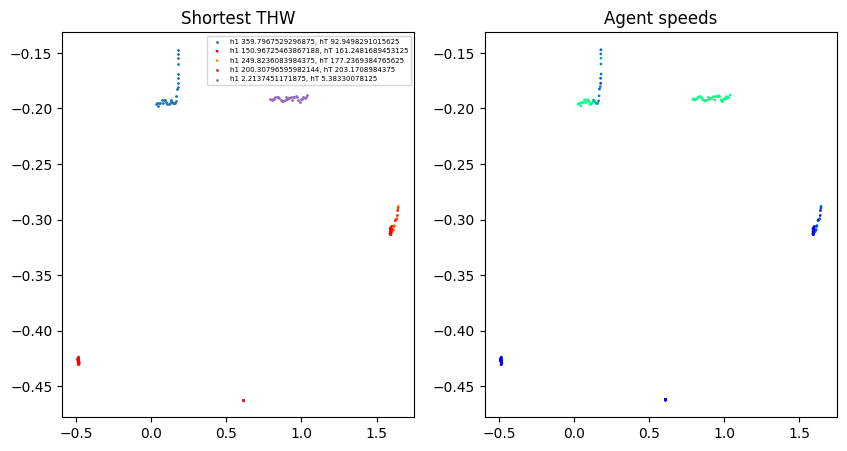

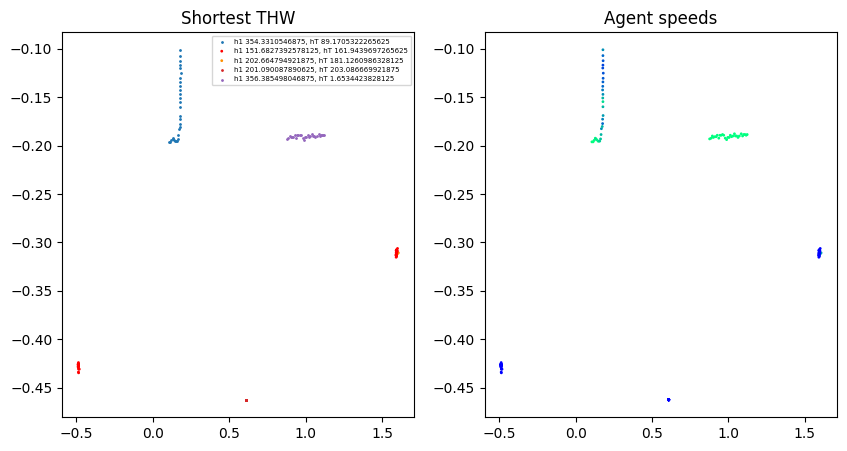

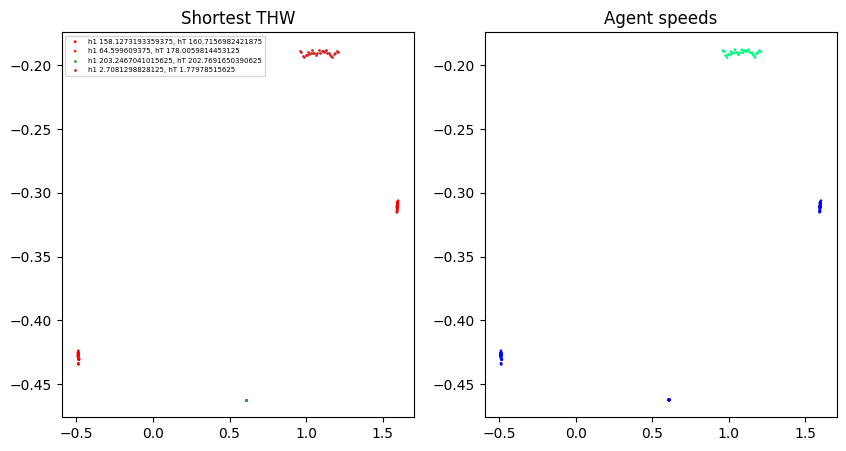

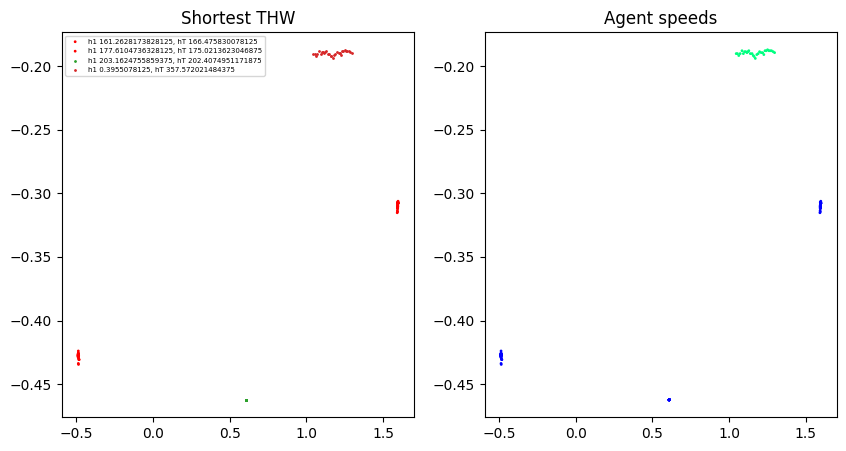

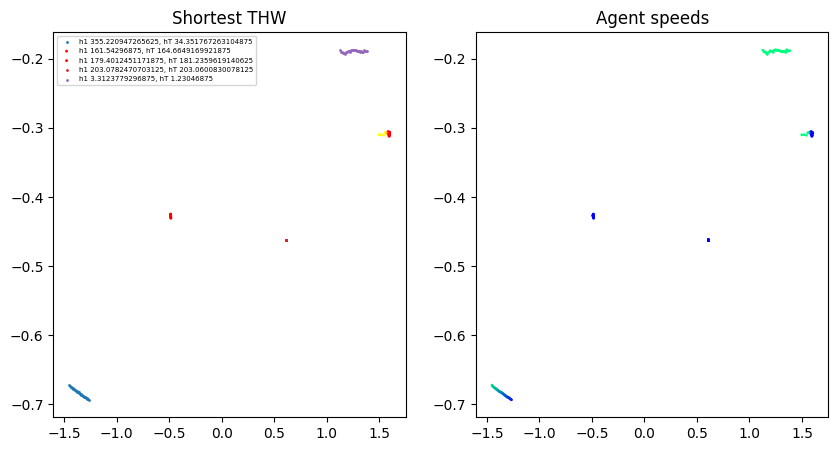

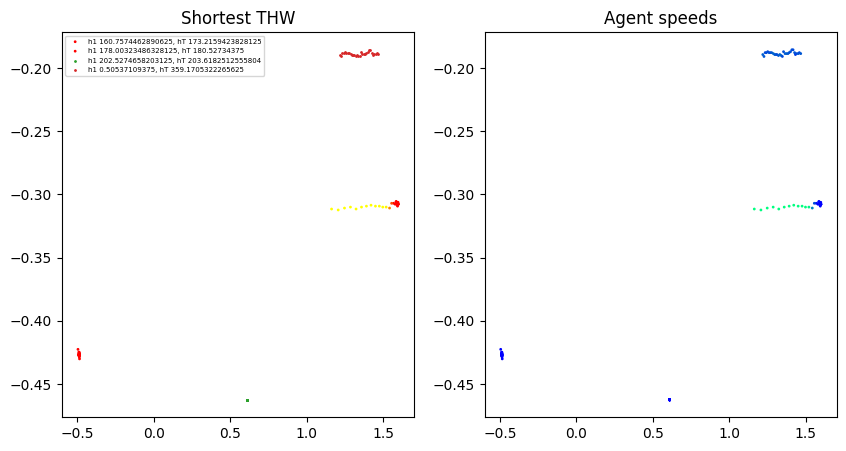

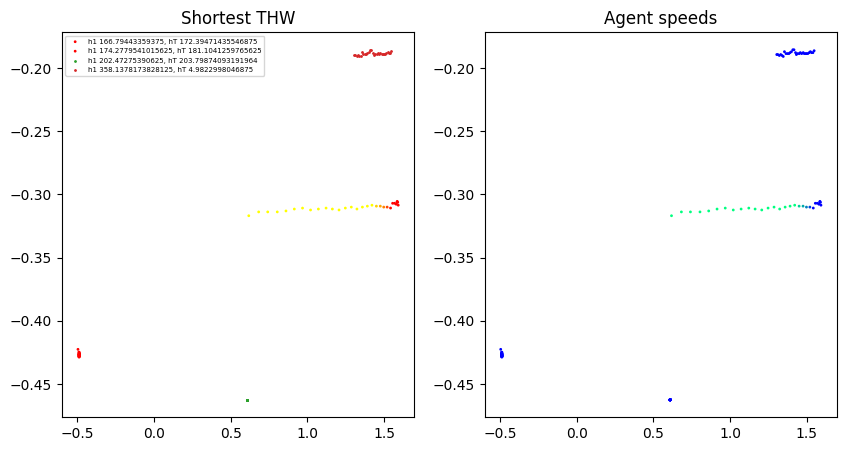

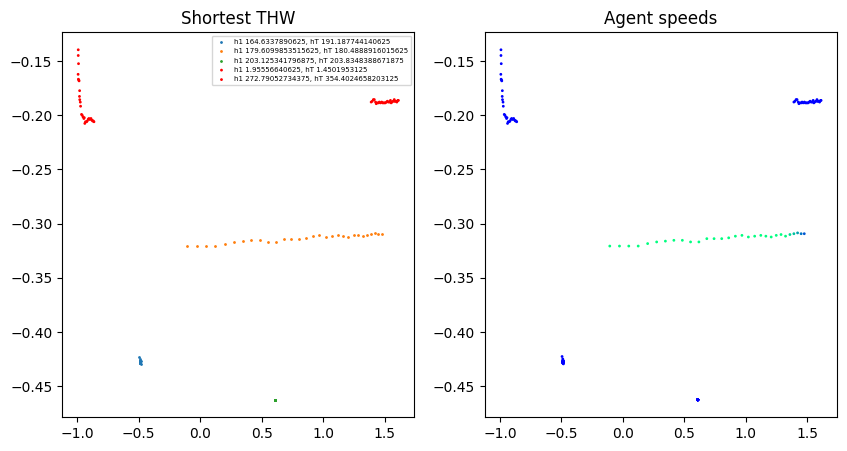

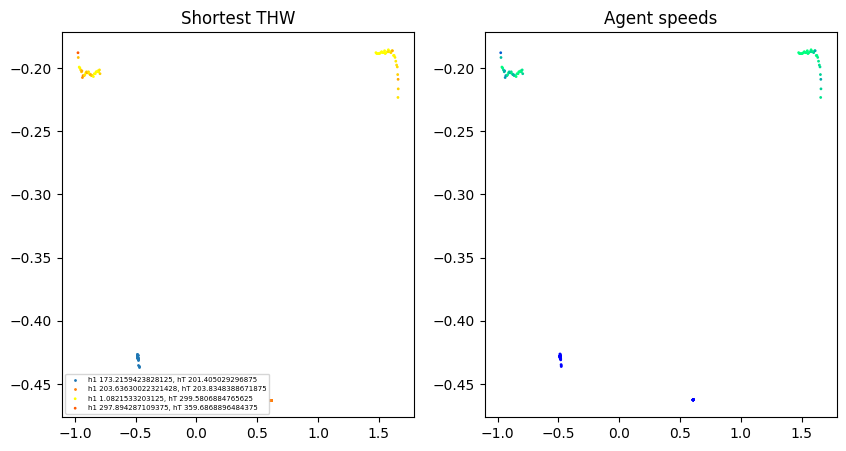

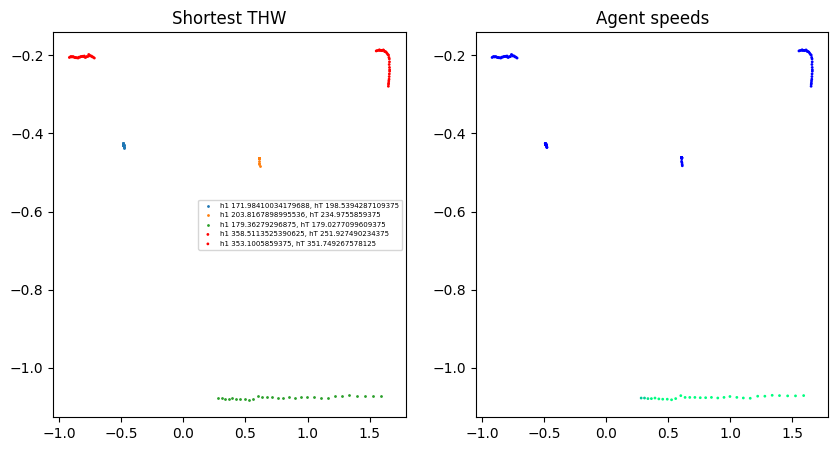

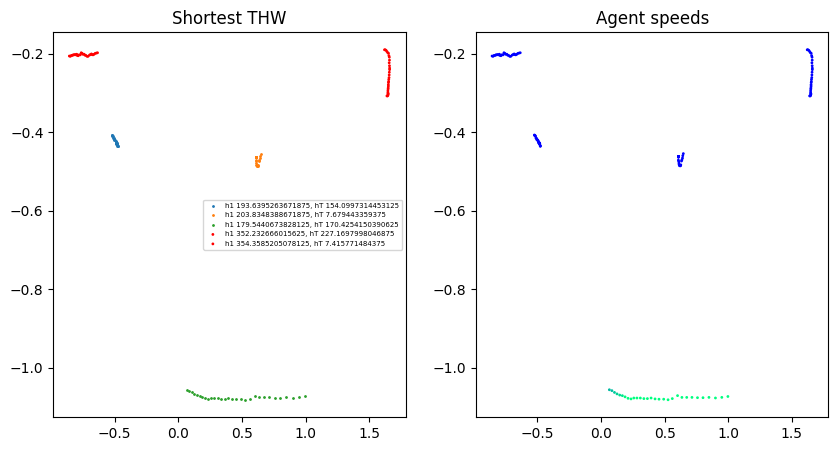

In [335]:
THW_THRESH = 5
scenes_thw = []
agent_ids = []
critical_scenes, csc = 10, 0
max_agents = 5
for i, (start, end) in enumerate(seq_start_end):
    if end - start > max_agents:
        continue
    scene = sequences[start:end, :, idx]
    thw, agents = compute_scene_scores(scene)
    if thw.min() <= THW_THRESH:
        IDs = agents[thw.argmin()]
        plot_critical_metric(scene, IDs)
        if critical_scenes == csc:
            break
        csc += 1
    scenes_thw.append(thw)
    agent_ids.append(agents)

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  3.,  3.,  9., 11.,  9.]),
 array([-12.48791, -12.3618 , -12.23569, -12.10957, -11.98346, -11.85735,
        -11.73124, -11.60512, -11.47901, -11.3529 , -11.22679, -11.10067,
        -10.97456, -10.84845, -10.72234, -10.59623, -10.47011, -10.344  ,
        -10.21789, -10.09178,  -9.96566,  -9.83955,  -9.71344,  -9.58733,
         -9.46121,  -9.3351 ,  -9.20899,  -9.08288,  -8.95676,  -8.83065,
         -8.70454,  -8.57843,  -8.45231,  -8.3262 ,  -8.20009,  

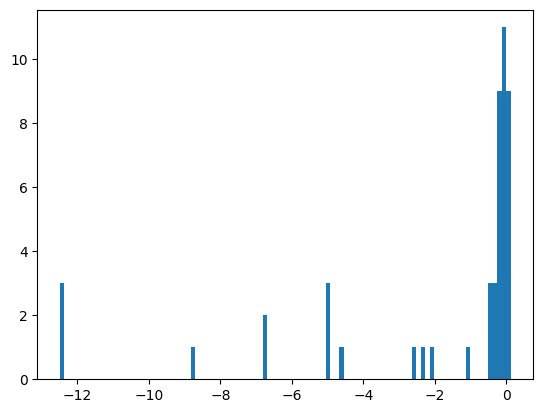

In [336]:

all_thw = np.concatenate(scenes_thw)
all_thw_filtered = all_thw[np.where(all_thw < float('inf'))]
# all_thw_filtered = all_thw[np.where(all_thw < 10)]
plt.hist(all_thw_filtered, bins=100)



In [337]:
# thw_seq.shape